# Principal Component Analysis

In [28]:
import consts
import helper
import importlib
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import sklearn, scipy, requests
import random
from sklearn.preprocessing import StandardScaler


In [2]:
FILE_PATH = consts.RAW_DATA_PATH_RYAN

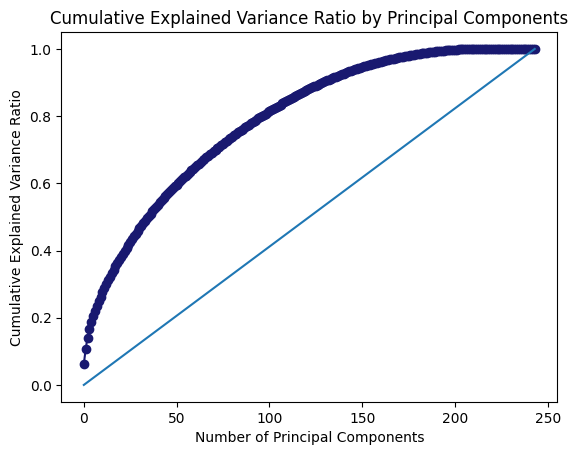

In [84]:
importlib.reload(helper)
df = pd.read_csv(FILE_PATH + 'data.20211223_1200')
df = df[df.columns[8:]] # cut out the test data
helper.pca_plot(df, num_components=244)

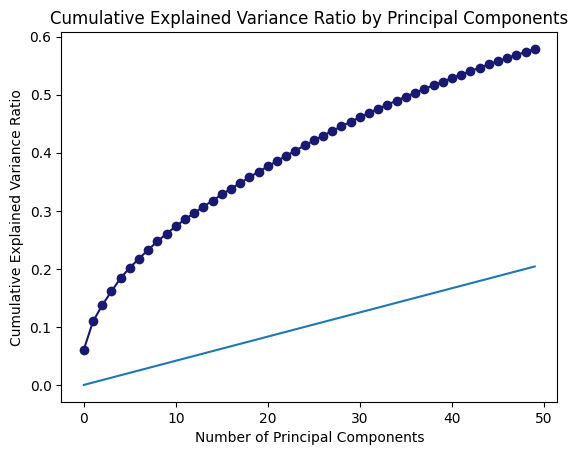

In [85]:
df = pd.read_csv(FILE_PATH + 'data.20200316_1200')
df.columns
df = df[df.columns[7:]] # cut out testing columns
helper.pca_plot(df, num_components=50)

## Regressions with PCA

In [3]:
USER = "RYAN"
RESPONSE_NAME = consts.RESPONSE_NAME

LASSO = "LASSO"
XGBOOST = "XGBOOST"

ALPHA = 0.05 # Set significance level

TEST_START  = "20210202"
TRAIN_TEST_GAP = 31 # days

In [36]:
importlib.reload(helper)
data = helper.Data(train_data_path=FILE_PATH)
# 6 months
train_df = data.update_and_get_train_df(TEST_START, backward_dayCount= 31, years_count = 0, train_data_count=182)
test_dfs = data.update_and_get_test_df(data_path = FILE_PATH, start_date=TEST_START, end_date="20210301")

# cut out response columns
transforming_cols = train_df.columns[7:]
validation_data = train_df[RESPONSE_NAME]
#get the transformed training data
train_df = train_df[transforming_cols]
test_xs = [df[transforming_cols] for df in test_dfs]

No YYYYMMDD datetime matched.

Getting files from 2020-07-04 00:00:00 to 2021-01-02 00:00:00, inclusive.
Filtered File Dates: ['data.20200706_1200', 'data.20200707_1200', 'data.20200708_1200', 'data.20200709_1200', 'data.20200710_1200', 'data.20200713_1200', 'data.20200714_1200', 'data.20200715_1200', 'data.20200716_1200', 'data.20200717_1200', 'data.20200720_1200', 'data.20200721_1200', 'data.20200722_1200', 'data.20200723_1200', 'data.20200724_1200', 'data.20200727_1200', 'data.20200728_1200', 'data.20200729_1200', 'data.20200730_1200', 'data.20200731_1200', 'data.20200803_1200', 'data.20200804_1200', 'data.20200805_1200', 'data.20200806_1200', 'data.20200807_1200', 'data.20200810_1200', 'data.20200811_1200', 'data.20200812_1200', 'data.20200813_1200', 'data.20200814_1200', 'data.20200817_1200', 'data.20200818_1200', 'data.20200819_1200', 'data.20200820_1200', 'data.20200821_1200', 'data.20200824_1200', 'data.20200825_1200', 'data.20200826_1200', 'data.20200827_1200', 'data.20200828_

In [37]:
# Scale the data
scalar = StandardScaler()
train_df = scalar.fit_transform(train_df)

In [55]:
# Fit PCA
pca = sklearn.decomposition.PCA(n_components=40)
pca.fit(train_df)

PCA(n_components=40)

In [56]:
# Fit Transform X training data
train_df_pca = pd.DataFrame(pca.transform(train_df))
# add on the original y values 
train_df_pca[RESPONSE_NAME] = validation_data.values # leave untransformed

scaled_test = [pd.DataFrame(scalar.fit_transform(df)) for df in test_xs]
transformed_test = [pd.DataFrame(pca.transform(df)) for df in scaled_test]
test_dfs_pca = []
for pca_df, df in zip(transformed_test, test_dfs):
    pca_df[RESPONSE_NAME] = df[RESPONSE_NAME]
    test_dfs_pca.append(pca_df)


In [57]:
importlib.reload(helper)
full_ols_model = helper.Model('OLS')
full_ols_model.train(pd.DataFrame(train_df_pca))
predictions = full_ols_model.test(test_dfs_pca)

You're using: OLS.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
No. features being used: 40
response_corr: 0.0192871433001642
mean_return: 6.163897511572177e-05
scale_factor: 0.33450247078381506


In [58]:
importlib.reload(helper)
lasso_model = helper.Model(LASSO)
lasso_model.train(pd.DataFrame(train_df_pca))
predictions = lasso_model.test(test_dfs_pca)

You're using: LASSO.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': False}
No. features being used: 40
response_corr: 0.021004711849871342
mean_return: 0.0001280636222022811
scale_factor: 0.49570110177178006


In [59]:
importlib.reload(helper)
xgboost_model = helper.Model(XGBOOST)
xgboost_model.train(pd.DataFrame(train_df_pca))
predictions = xgboost_model.test(test_dfs_pca)

You're using: XGBOOST.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_pa